In [1]:
import sys
sys.path.append("..")

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import math
import tensorflow as tf
import transforming_dynamics_model
import dynamics_model
import dynamics_subtractive_model

import tf_utils

In [2]:
from experiments.large import touch_ld_mu5_1e1_fixed as trainer
from utils_vpred import create_gif

In [3]:
tf.reset_default_graph()
conf = trainer.new_conf
model = transforming_dynamics_model.DynamicsModel(conf)

setting up network
OrderedDict([('default', True), ('experiment_name', 'touch'), ('transform', 'none'), ('data', 'touchld'), ('data_dir', '/home/ashvin/lsdc/pushing_data/touch_ld'), ('sequence_length', 15), ('skip_frame', 1), ('context_frames', 2), ('use_state', 1), ('train_val_split', 1.0), ('batch_size', 32), ('learning_rate', 0.001), ('visualize', ''), ('file_visual', ''), ('discretize', 20), ('fsize', 32), ('masks', 0), ('run', 0), ('mu1', 0), ('mu2', 1e-06), ('mu3', 1), ('mu4', 0), ('mu5', 0.1), ('seq', 0), ('autoencoder', 'decode'), ('forwardloss', 'gaussian'), ('featactivation', 'none'), ('padding', 'valid'), ('loadalldata', 0), ('miningtemp', 0), ('initialize', 0), ('touch', 'Wclassify')])
using frame sequence:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
using frame sequence:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
image features: (batch, featsize) (?, 32)
done with network setup


In [4]:
f = model.get_f(query=[model.image_batch] + model.touch_preds + model.action_losses + [model.touch_batch, model.inverse_loss_batch, model.raw_touch_batch])

RESTORING FROM
/data2/shared/tf-lsdc/tf-data/tf_models/experiment_name_touch/transform_none/data_touchld/skip_frame_1/fsize_32/mu2_1e-06/mu5_0.1/touch_Wclassify
Checkpoint found and restored: /data2/shared/tf-lsdc/tf-data/tf_models/experiment_name_touch/transform_none/data_touchld/skip_frame_1/fsize_32/mu2_1e-06/mu5_0.1/touch_Wclassify/model-50000


In [5]:
result = model.run('test', batches=10, f=f)

In [6]:
values = result[0]

In [7]:
tp, fp, tn, fn = 0, 0, 0, 0
for i in range(14):
    T = np.reshape(values[model.touch_batch][:, i, :, :], [32, 20, 1])
    t = values[model.touch_preds[i]] > 0
    tp += np.sum(np.logical_and(T == 1, t == 1))
    fp += np.sum(np.logical_and(T == 0, t == 1))
    tn += np.sum(np.logical_and(T == 0, t == 0))
    fn += np.sum(np.logical_and(T == 1, t == 0))
print tp, fp, tn, fn
S = float(tp + fp + tn + fn)
print tp/S, fp/S, tn/S, fn/S
print "T=1", (tp + fn)/S

373 1514 6823 250
0.0416294642857 0.168973214286 0.761495535714 0.0279017857143
T=1 0.06953125


In [13]:
no_touch_loss = []
touch_loss = []

B = 10 # 100
F = 14 # 14
for b in range(B):
    values = result[b]
    for i in range(F):
        T = np.reshape(values[model.touch_batch][:, i, :, :], [32, 20, 1])
#         print T
#         print values[model.raw_touch_batch][:, i, :], [32, 20, 1]
        a = result[b][model.action_losses[i]]
        for j in range(32):
            if np.all(0 == T[j, :, :]):
                no_touch_loss.append(a[j])
            else:
                touch_loss.append(a[j])

In [14]:
len(no_touch_loss)

2720

In [15]:
len(touch_loss)

1760

1.92645
0.966235


(array([  1.56500000e+03,   8.69000000e+02,   1.79000000e+02,
          5.70000000e+01,   2.60000000e+01,   7.00000000e+00,
          3.00000000e+00,   2.00000000e+00,   2.00000000e+00,
          1.00000000e+00,   0.00000000e+00,   3.00000000e+00,
          2.00000000e+00,   1.00000000e+00,   1.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   2.00000000e+00]),
 array([  0.90755606,   1.76812632,   2.62869658,   3.48926685,
          4.34983711,   5.21040738,   6.07097764,   6.9315479 ,
          7.79211817,   8.65268843,   9.5132587 ,  10.37382896,
         11.23439922,  12.09496949,  12.95553975,  13.81611001,
         14.67668028,  15.53725054,  16.39782081,  17.25839107,  18.11896133]),
 <a list of 20 Patch objects>)

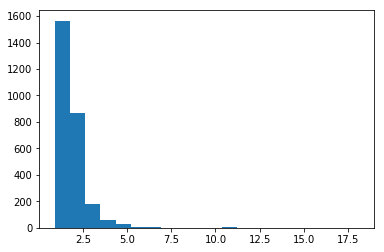

In [16]:
no_touch_loss = np.array(no_touch_loss)
print np.mean(no_touch_loss)
print np.std(no_touch_loss)
plt.hist(no_touch_loss, 20)

2.27673
0.746755


(array([  31.,  550.,  487.,  295.,  162.,   94.,   47.,   42.,   23.,
          14.,    4.,    1.,    3.,    2.,    2.,    0.,    0.,    0.,
           2.,    1.]),
 array([ 1.10586452,  1.48027635,  1.85468817,  2.22909999,  2.60351181,
         2.97792363,  3.35233545,  3.72674727,  4.1011591 ,  4.47557092,
         4.84998274,  5.22439456,  5.59880638,  5.9732182 ,  6.34763002,
         6.72204185,  7.09645367,  7.47086549,  7.84527731,  8.21968913,
         8.59410095]),
 <a list of 20 Patch objects>)

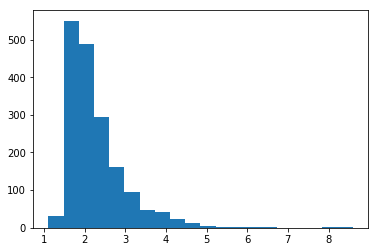

In [17]:
touch_loss = np.array(touch_loss)
print np.mean(touch_loss)
print np.std(touch_loss)
plt.hist(touch_loss, 20)

In [18]:
# reconstructions = result.values()[16:]
image_data = result[0][model.image_batch]
# print len(reconstructions)
# print reconstructions[0].shape

In [9]:
ims = create_gif.assemble_gif(reconstructions)
create_gif.npy_to_gif(ims, "media/test")

video length: 32


IndexError: tuple index out of range

In [12]:
for b in range(32):
    ims = []
    for i in range(14):
        pred_im = (reconstructions[i][b, :, :, :] + img_mean) * 256
        real_im = image_data[b, i+1, :, :, :] * 256
        im = np.concatenate([pred_im, real_im], 1)
        ims.append(im)
    create_gif.npy_to_gif(ims, "media/traj/traj"+str(b))


[MoviePy] Building file media/traj/traj0.gif with imageio


 93%|█████████▎| 14/15 [00:00<00:00, 104.82it/s]


[MoviePy] Building file media/traj/traj1.gif with imageio



 93%|█████████▎| 14/15 [00:00<00:00, 164.80it/s]


[MoviePy] Building file media/traj/traj2.gif with imageio



 93%|█████████▎| 14/15 [00:00<00:00, 179.38it/s]


[MoviePy] Building file media/traj/traj3.gif with imageio



 93%|█████████▎| 14/15 [00:00<00:00, 185.07it/s]


[MoviePy] Building file media/traj/traj4.gif with imageio



 93%|█████████▎| 14/15 [00:00<00:00, 187.13it/s]


[MoviePy] Building file media/traj/traj5.gif with imageio



 93%|█████████▎| 14/15 [00:00<00:00, 182.47it/s]


[MoviePy] Building file media/traj/traj6.gif with imageio



 93%|█████████▎| 14/15 [00:00<00:00, 179.54it/s]


[MoviePy] Building file media/traj/traj7.gif with imageio



 93%|█████████▎| 14/15 [00:00<00:00, 185.01it/s]


[MoviePy] Building file media/traj/traj8.gif with imageio



 93%|█████████▎| 14/15 [00:00<00:00, 184.79it/s]


[MoviePy] Building file media/traj/traj9.gif with imageio



 93%|█████████▎| 14/15 [00:00<00:00, 185.95it/s]


[MoviePy] Building file media/traj/traj10.gif with imageio



 93%|█████████▎| 14/15 [00:00<00:00, 193.55it/s]


[MoviePy] Building file media/traj/traj11.gif with imageio



 93%|█████████▎| 14/15 [00:00<00:00, 201.59it/s]


[MoviePy] Building file media/traj/traj12.gif with imageio



 93%|█████████▎| 14/15 [00:00<00:00, 190.80it/s]


[MoviePy] Building file media/traj/traj13.gif with imageio



 93%|█████████▎| 14/15 [00:00<00:00, 192.96it/s]


[MoviePy] Building file media/traj/traj14.gif with imageio



 93%|█████████▎| 14/15 [00:00<00:00, 194.82it/s]


[MoviePy] Building file media/traj/traj15.gif with imageio



 93%|█████████▎| 14/15 [00:00<00:00, 190.54it/s]


[MoviePy] Building file media/traj/traj16.gif with imageio



 93%|█████████▎| 14/15 [00:00<00:00, 188.43it/s]


[MoviePy] Building file media/traj/traj17.gif with imageio



 93%|█████████▎| 14/15 [00:00<00:00, 206.81it/s]


[MoviePy] Building file media/traj/traj18.gif with imageio



 93%|█████████▎| 14/15 [00:00<00:00, 102.24it/s]


[MoviePy] Building file media/traj/traj19.gif with imageio



 93%|█████████▎| 14/15 [00:00<00:00, 169.86it/s]


[MoviePy] Building file media/traj/traj20.gif with imageio



 93%|█████████▎| 14/15 [00:00<00:00, 179.37it/s]


[MoviePy] Building file media/traj/traj21.gif with imageio



 93%|█████████▎| 14/15 [00:00<00:00, 184.53it/s]


[MoviePy] Building file media/traj/traj22.gif with imageio



 93%|█████████▎| 14/15 [00:00<00:00, 181.92it/s]


[MoviePy] Building file media/traj/traj23.gif with imageio



 93%|█████████▎| 14/15 [00:00<00:00, 182.46it/s]


[MoviePy] Building file media/traj/traj24.gif with imageio



 93%|█████████▎| 14/15 [00:00<00:00, 190.42it/s]


[MoviePy] Building file media/traj/traj25.gif with imageio



 93%|█████████▎| 14/15 [00:00<00:00, 192.08it/s]


[MoviePy] Building file media/traj/traj26.gif with imageio



 93%|█████████▎| 14/15 [00:00<00:00, 184.25it/s]


[MoviePy] Building file media/traj/traj27.gif with imageio



 93%|█████████▎| 14/15 [00:00<00:00, 204.78it/s]


[MoviePy] Building file media/traj/traj28.gif with imageio



 93%|█████████▎| 14/15 [00:00<00:00, 202.38it/s]


[MoviePy] Building file media/traj/traj29.gif with imageio



 93%|█████████▎| 14/15 [00:00<00:00, 203.05it/s]


[MoviePy] Building file media/traj/traj30.gif with imageio



 93%|█████████▎| 14/15 [00:00<00:00, 205.01it/s]


[MoviePy] Building file media/traj/traj31.gif with imageio



 93%|█████████▎| 14/15 [00:00<00:00, 206.98it/s]


In [7]:
reconstructions

NameError: name 'reconstructions' is not defined

In [8]:
def draw_action_pair(img1, img2, u_actual, u_pred):
    f, ax = plt.subplots(1, 4)
    ax[0].imshow(img1)
    ax[1].imshow(img2)
    ax[2].imshow(u_actual.T)
    ax[3].imshow(u_pred.T)

/home/ashvin/tensorflow11/local/lib/python2.7/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


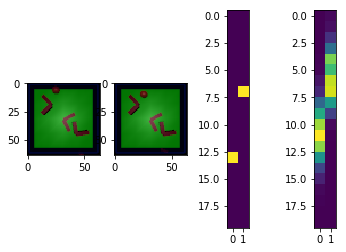

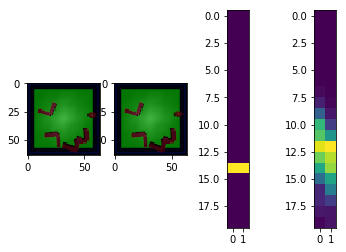

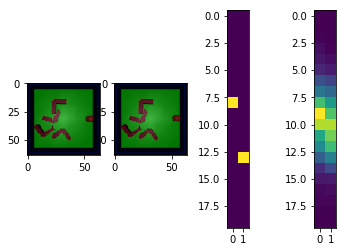

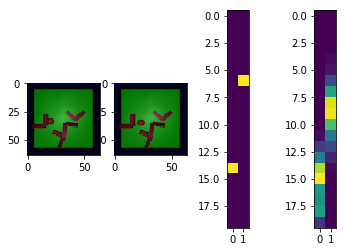

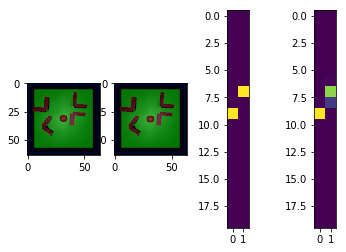

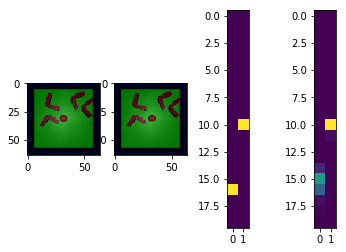

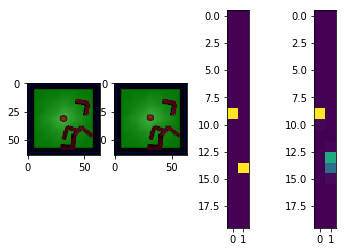

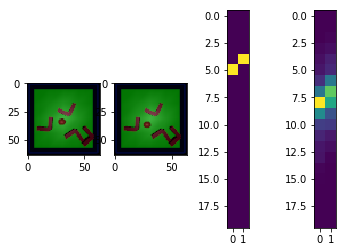

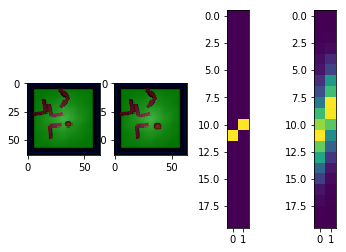

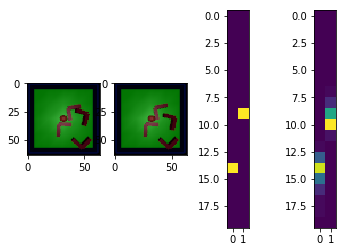

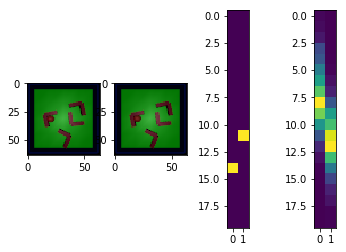

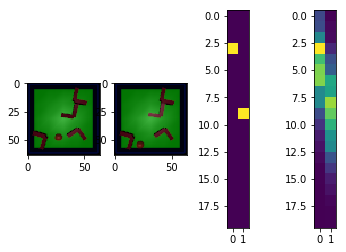

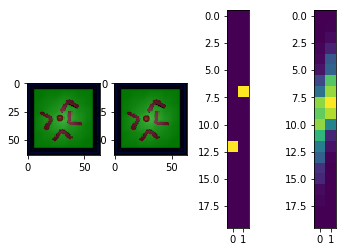

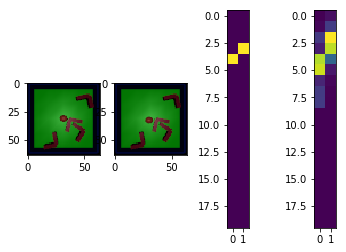

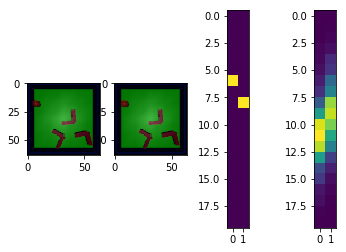

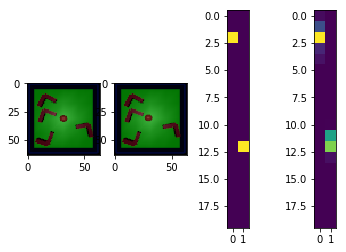

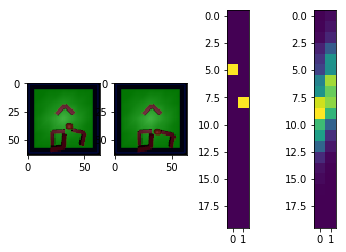

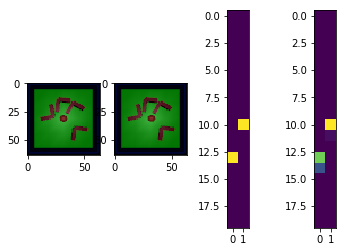

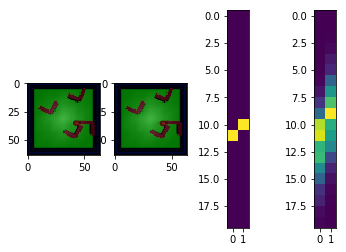

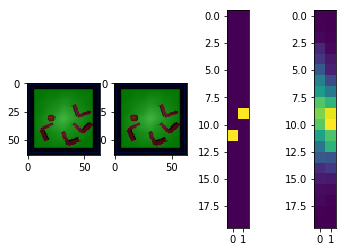

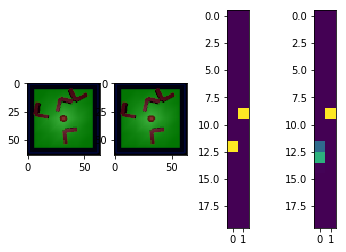

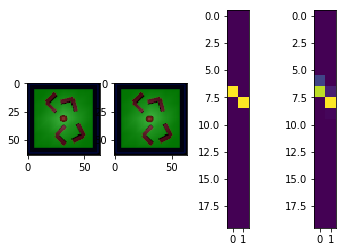

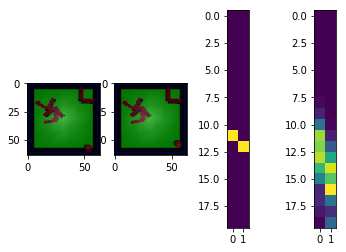

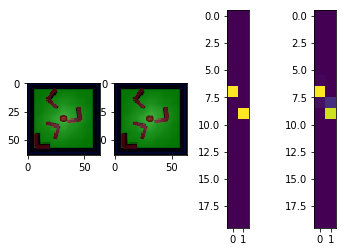

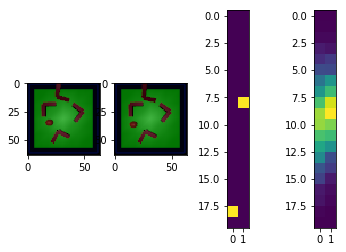

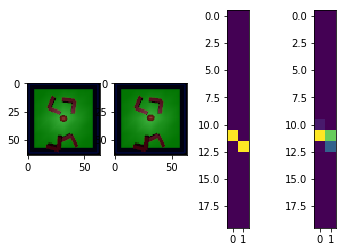

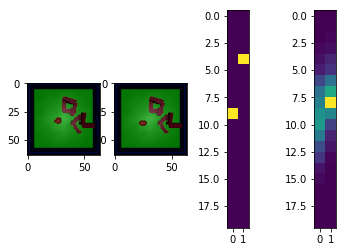

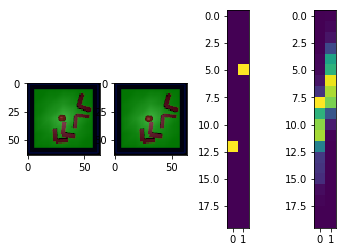

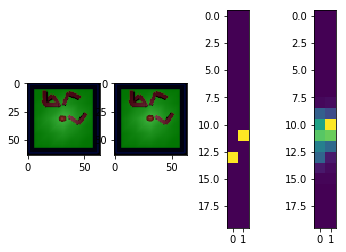

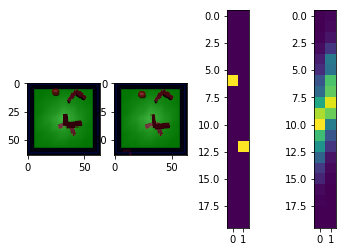

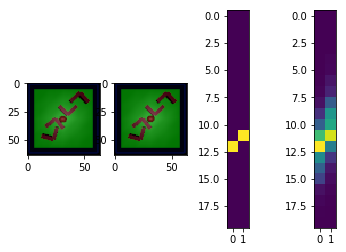

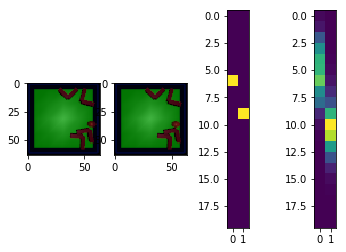

In [9]:
import discretize

B = 32
for b in range(B):
    img1 = image_data[b, 0, :, :, :]
    img2 = image_data[b, 1, :, :, :]
    
    u_actual = np.array([
        discretize.one_hot_encode(A[b, 0, 0], -10, 10, 20),
        discretize.one_hot_encode(A[b, 0, 1], -10, 10, 20)])
    
    u_pred = np.array([softmax(a[b, 0, :]), softmax(a[b, 1, :])])
    
    draw_action_pair(img1, img2, u_actual, u_pred)

In [10]:
print [v.name for v in tf.trainable_variables()]

[u'conv/conv1/weights:0', u'conv/conv1/biases:0', u'conv/conv2/weights:0', u'conv/conv2/biases:0', u'conv/conv3/weights:0', u'conv/conv3/biases:0', u'conv/conv4/weights:0', u'conv/conv4/biases:0', u'conv/fc5/weights:0', u'conv/fc5/biases:0', u'autodecoder/fc5/weights:0', u'autodecoder/fc5/biases:0', u'autodecoder/conv1/weights:0', u'autodecoder/conv1/biases:0', u'autodecoder/conv2/weights:0', u'autodecoder/conv2/biases:0', u'autodecoder/conv3/weights:0', u'autodecoder/conv3/biases:0', u'autodecoder/conv4/weights:0', u'autodecoder/conv4/biases:0', u'actionpred/fc_1/weights:0', u'actionpred/fc_1/biases:0', u'actionpred/fc_2/weights:0', u'actionpred/fc_2/biases:0', u'forwardpred/fc_1/weights:0', u'forwardpred/fc_1/biases:0', u'forwardpred/fc_2/weights:0', u'forwardpred/fc_2/biases:0', u'forwardpred/fc_3/weights:0', u'forwardpred/fc_3/biases:0', u'iteration:0']


In [11]:
var = [v for v in tf.trainable_variables() if v.name == "conv/conv1/weights:0"][0]

In [12]:
C1 = var.eval()
print C1.shape

(6, 6, 3, 32)


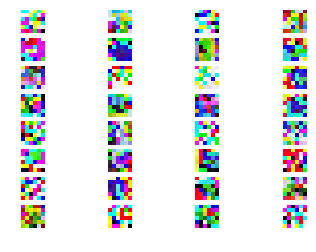

In [13]:
f, ax = plt.subplots(8, 4)
for i in range(32):
    ax[i % 8, i // 8].imshow(C1[:, :, :, i])
    ax[i % 8, i // 8].axis("off")

In [14]:
print 'action:', action_data.shape
print 'action: batch ind 0', action_data[0]
print 'action: batch ind 1', action_data[1]
print 'images:', image_data.shape

# print 'states:', state_data.shape
# print 'states: batch ind 0', state_data[0]
# print 'states: batch ind 1', state_data[1]
# print 'average speed in dir1:', np.average(state_data[:,:,3])
# print 'average speed in dir2:', np.average(state_data[:,:,2])

action: (32, 15, 2)
action: batch ind 0 [[ 3.33545136 -2.25861216]
 [ 3.33545136 -2.25861216]
 [ 3.33545136 -2.25861216]
 [ 2.15756798 -1.811216  ]
 [ 2.15756798 -1.811216  ]
 [ 2.15756798 -1.811216  ]
 [-0.75817072  2.09110522]
 [-0.75817072  2.09110522]
 [-0.75817072  2.09110522]
 [-1.85879886 -2.16974783]
 [-1.85879886 -2.16974783]
 [-1.85879886 -2.16974783]
 [ 2.71735048  0.21799408]
 [ 2.71735048  0.21799408]
 [ 2.71735048  0.21799408]]
action: batch ind 1 [[ 4.76455307  4.33923197]
 [ 4.76455307  4.33923197]
 [ 4.76455307  4.33923197]
 [-2.85598803 -1.27550304]
 [-2.85598803 -1.27550304]
 [-2.85598803 -1.27550304]
 [-4.48170042 -1.4973582 ]
 [-4.48170042 -1.4973582 ]
 [-4.48170042 -1.4973582 ]
 [ 0.53662127 -6.43230391]
 [ 0.53662127 -6.43230391]
 [ 0.53662127 -6.43230391]
 [ 0.57038349 -0.46015605]
 [ 0.57038349 -0.46015605]
 [ 0.57038349 -0.46015605]]
images: (32, 15, 64, 64, 3)


In [15]:
print np.max(image_data)

0.694118


In [16]:
action_data.shape

(32, 15, 2)

(array([   3.,    3.,   45.,  102.,  231.,  234.,  213.,   96.,   21.,   12.]),
 array([-11.55987358,  -9.44079809,  -7.3217226 ,  -5.20264711,
         -3.08357162,  -0.96449614,   1.15457935,   3.27365484,
          5.39273033,   7.51180582,   9.63088131]),
 <a list of 10 Patch objects>)

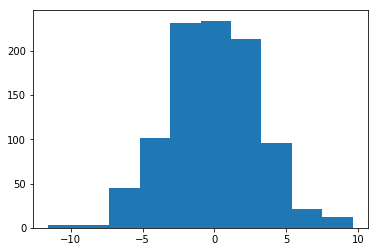

In [17]:
x = action_data.flatten()
plt.hist(x)

In [18]:
np.max(action_data)

9.6308813

In [19]:
np.min(action_data)

-11.559874

In [20]:
image_data.shape

(32, 15, 64, 64, 3)

In [21]:
I = image_data[:, 0:14, :, :, :] - image_data[0, 1:15, :, :, :]
print I.min(), I.max()

-0.694118 0.545098


In [22]:
def showable(img):
    image_data

In [23]:
np.min(image_data)

0.0

0.617822
4.90196e-07
(64, 64, 3)


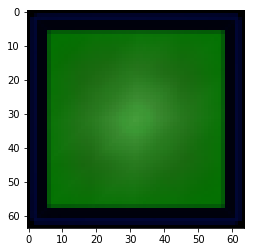

In [11]:
img_mean = np.load('/home/ashvin/lsdc/pushing_data/finer_temporal_resolution_substep10/train/mean.npy')
plt.imshow(img_mean)
img_mean.dtype
print np.max(img_mean)
print np.min(img_mean)
print img_mean.shape

In [41]:
print model.raw_touch_batch.get_shape()

(?, 15, 20)


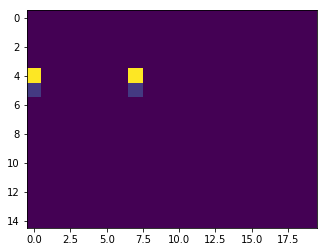

In [80]:
plt.imshow(values[model.raw_touch_batch][1, :, :])

In [22]:
values = result[0]

(20, 1)
(20,)
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.]
(20, 1)
(20,)
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.]
(20, 1)
(20,)
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.]
(20, 1)
(20,)
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.]
(20, 1)
(20,)
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.]
(20, 1)
(20,)
[ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.
  0.  0.]
[  

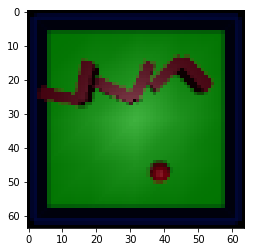

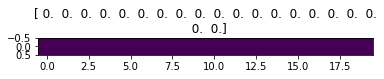

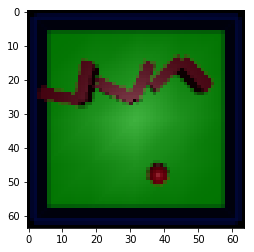

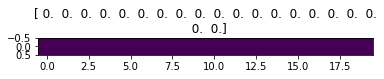

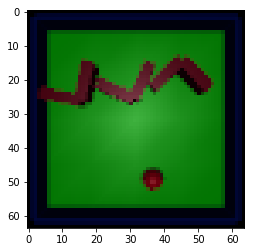

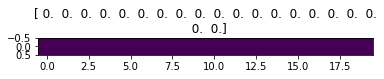

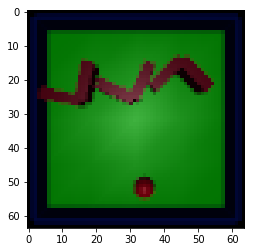

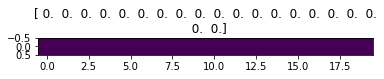

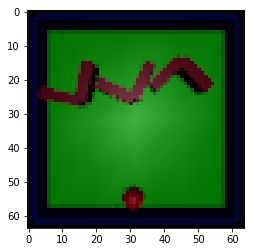

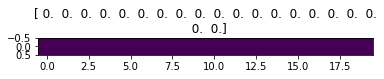

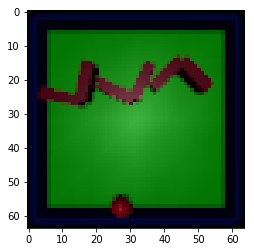

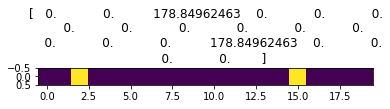

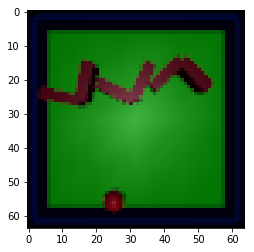

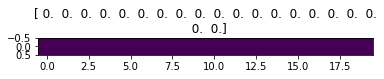

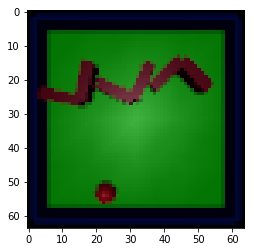

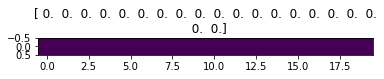

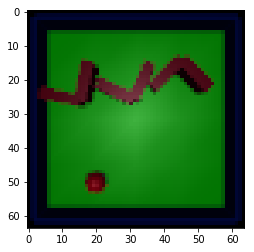

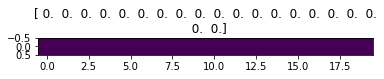

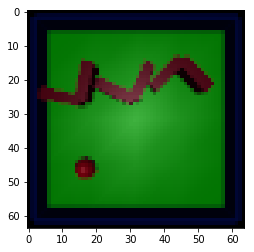

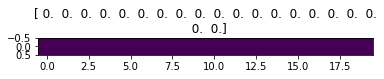

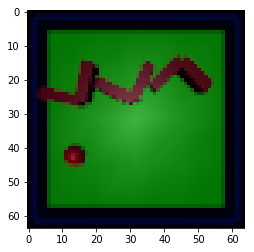

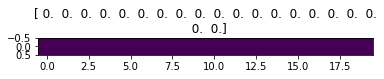

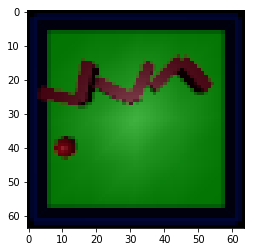

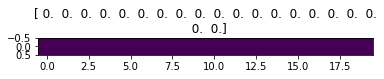

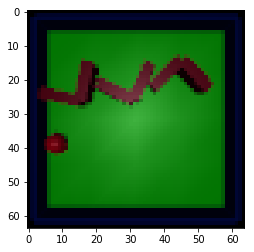

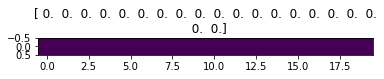

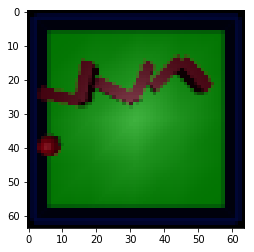

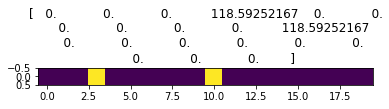

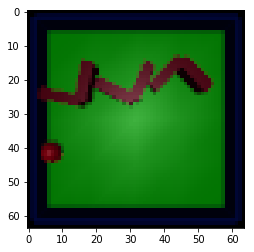

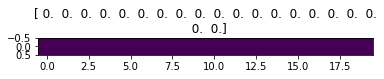

In [24]:
n = 5
for i in range(15):
    plt.figure()
#     f, ax = plt.subplots(1, 2)
    plt.imshow(image_data[n, i, :, :, :])
    plt.figure()
    
    j = i
    T = values[model.touch_batch][n, j, :, :]
    Traw = values[model.raw_touch_batch][n, j, :]
    plt.imshow(Traw.flatten()[:, None].T)
    print T.shape
    print Traw.shape
    print T.flatten()
    print Traw.flatten()
    plt.title(Traw.flatten())
#     a = result[b][model.action_losses[i]]
#     for j in range(32):
#         if np.all(0 == T[:, :]):
#             no_touch_loss.append(a[j])
#         else:
#             touch_loss.append(a[j])